# Mushroom TinyML: Balanced Sampling & Collaborative Optimization

**Target:** ESP32-S3 (Int8 TFLite)  
**Features:**
1.  **Balanced Sampling:** Creates equal-probability sampling from all classes to handle imbalance.
2.  **Data Augmentation:** Rotation, Flip, Zoom, Contrast adjustments.
3.  **Optimization:** Pruning -> Clustering -> QAT.

In [1]:
# 1. STRICT VERSION FIX (Run Once & Restart Kernel)
# This fixes 'ModuleNotFoundError: No module named tensorflow.compat' 
# by installing compatible versions of TF and Keras.
!pip uninstall -y tensorflow tensorflow-intel tensorflow-gpu tf-keras keras tensorflow-model-optimization
!pip install tensorflow==2.15.0 tf_keras==2.15.0 tensorflow-model-optimization numpy pandas matplotlib

print("Install complete. PLEASE RESTART KERNEL NOW via 'Kernel > Restart'.")


Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: tensorflow-intel 2.15.0
Uninstalling tensorflow-intel-2.15.0:
  Successfully uninstalled tensorflow-intel-2.15.0
Found existing installation: tf-keras 2.15.0
Uninstalling tf-keras-2.15.0:
  Successfully uninstalled tf-keras-2.15.0
Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
Found existing installation: tensorflow-model-optimization 0.8.0
Uninstalling tensorflow-model-optimization-0.8.0:
  Successfully uninstalled tensorflow-model-optimization-0.8.0


  Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata (3.6 kB)
  Using cached tf_keras-2.15.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached tensorflow_model_optimization-0.8.0-py2.py3-none-any.whl.metadata (904 bytes)
  Using cached tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata (5.1 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl (2.1 kB)
Using cached tf_keras-2.15.0-py3-none-any.whl (1.7 MB)
Using cached tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl (300.9 MB)
Using cached tensorflow_model_optimization-0.8.0-py2.py3-none-any.whl (242 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
Install complete. PLEASE RESTART KERNEL NOW via 'Kernel > Restart'.


In [18]:
import os
import numpy as np
import tensorflow as tf
import tf_keras as keras  # Explicit Keras 2 import
from tf_keras import layers, models, optimizers
import tensorflow_model_optimization as tfmot
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tempfile
import zipfile

# Import our custom model file
from adam_efficientnet_lite_custom import EfficientNetLiteB0

# Set Seeds
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")


TensorFlow Version: 2.15.0
Keras Version: 2.15.0


In [3]:
CONFIG = {
    'DATA_DIR': Path("data/Mushrooms"),
    'IMG_SIZE': 240,
    'BATCH_SIZE': 32,
    'VAL_SPLIT': 0.2,
    'EPOCHS_BASELINE': 5,
    'EPOCHS_FINE_TUNE': 5,
    'LEARNING_RATE': 1e-3,
    'FINE_TUNE_LR': 1e-5,
    'NUM_CLUSTERS': 16,
    'SPARSITY': 0.50,
    'SEED': 42,
    'OUTPUT_DIR': Path("output_models")
}
CONFIG['OUTPUT_DIR'].mkdir(exist_ok=True, parents=True)


## 3. Balanced Dataset Pipeline with Augmentation

Scanning files...
Total images: 6713
Classes: ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


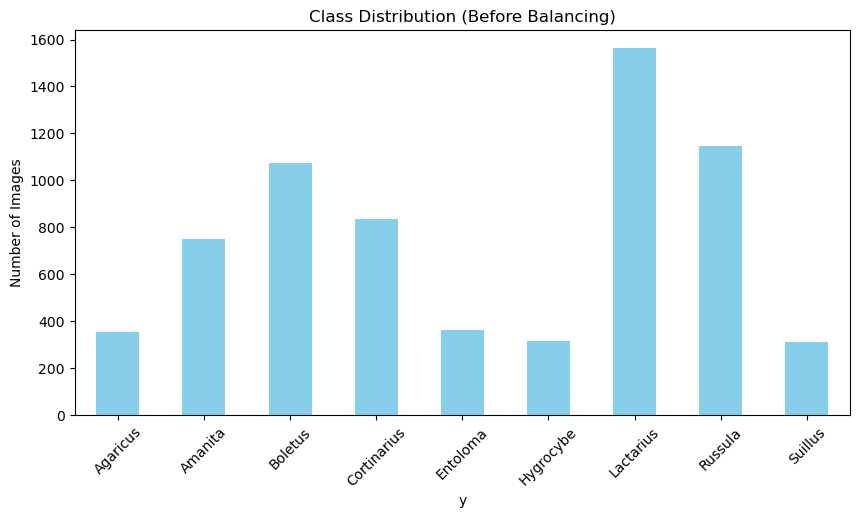

Train size: 5370
Val size: 1343


In [4]:
# 1. Build DataFrame from files
print("Scanning files...")
image_paths = []
labels = []
class_names = sorted([d.name for d in CONFIG["DATA_DIR"].iterdir() if d.is_dir()])
class_indices = {name: i for i, name in enumerate(class_names)}

for cls_name in class_names:
    cls_dir = CONFIG["DATA_DIR"] / cls_name
    for img_path in cls_dir.glob("*"):
        if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            image_paths.append(str(img_path))
            labels.append(class_indices[cls_name])

df = pd.DataFrame({'path': image_paths, 'y': labels})
print(f"Total images: {len(df)}")
print(f"Classes: {class_names}")

# 2. Graph Class Sizes
plt.figure(figsize=(10, 5))
df['y'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.title("Class Distribution (Before Balancing)")
plt.ylabel("Number of Images")
plt.show()

# 3. Split Data
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['y'], random_state=CONFIG["SEED"])
print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")


In [5]:
# --- CORRECTED DATASET PIPELINE ---
# Augmentation Layers
augment_layers = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
    keras.layers.RandomBrightness(0.1)
])

def load_img(path, label, training=False):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']])
    img = (img / 127.5) - 1.0  # Normalize to [-1, 1]
    
    if training:
        img = augment_layers(img, training=True)
    return img, label

# 1. Create one infinite dataset per class
per_class_datasets = []
num_classes = len(class_names)

print(f"Creating balanced streams for {num_classes} classes...")

for cls_idx in range(num_classes):
    # Get all paths for this specific class
    cls_paths = train_df[train_df['y'] == cls_idx]['path'].tolist()
    cls_labels = [cls_idx] * len(cls_paths)
    
    ds = tf.data.Dataset.from_tensor_slices((cls_paths, cls_labels))
    ds = ds.shuffle(buffer_size=min(1000, len(cls_paths)), seed=CONFIG['SEED'])
    ds = ds.repeat() # Infinite repeat needed for balancing
    
    # Apply loading & augmentation per class stream
    ds = ds.map(lambda p, y: load_img(p, y, training=True), num_parallel_calls=tf.data.AUTOTUNE)
    per_class_datasets.append(ds)

# 2. Sample Equally (The Fix)
# We want every class to have an equal 1/N chance of being picked.
# This ensures the model sees a perfectly flat histogram over time.
equal_weights = [1.0] * num_classes

balanced_train_ds = tf.data.Dataset.sample_from_datasets(
    per_class_datasets, 
    weights=equal_weights, 
    seed=CONFIG['SEED']
)

# 3. Batch and Prefetch
train_ds = balanced_train_ds.batch(CONFIG['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE)

# 4. Validation (No balancing needed, just raw data)
val_paths = val_df['path'].tolist()
val_labels = val_df['y'].tolist()
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(lambda p, y: load_img(p, y, training=False), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(CONFIG['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE)

print("Dataset pipeline fixed: Equal probability sampling active.")
import math
steps_per_epoch = max(1, math.ceil(len(train_df) / CONFIG['BATCH_SIZE']))
validation_steps = max(1, math.ceil(len(val_df) / CONFIG['BATCH_SIZE']))



Creating balanced streams for 9 classes...
Dataset pipeline fixed: Equal probability sampling active.


Sampling one full epoch to verify distribution...


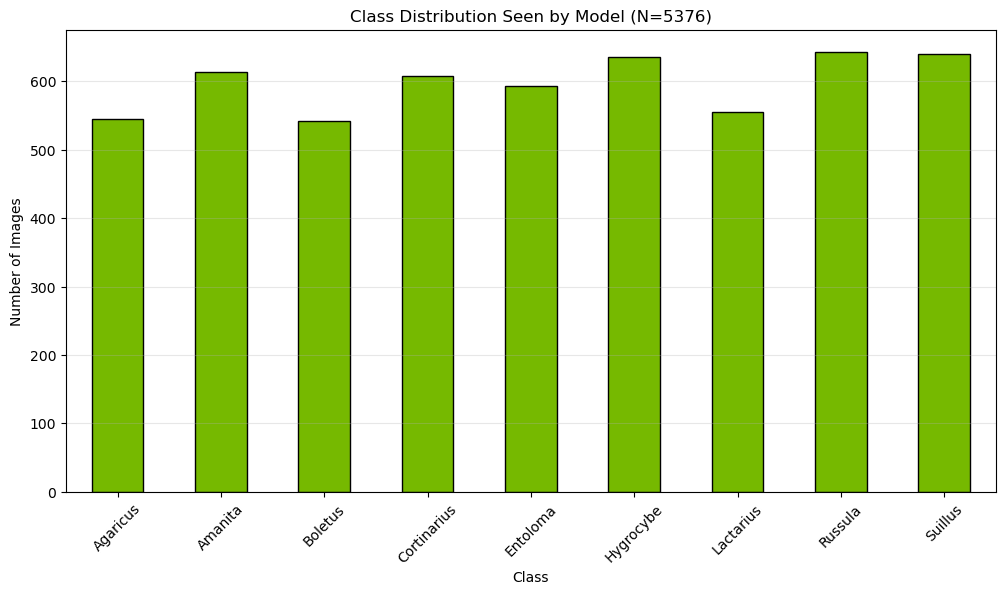

In [6]:
# --- VISUALIZATION: Verify Class Balance ---
import matplotlib.pyplot as plt
import pandas as pd

print("Sampling one full epoch to verify distribution...")
labels_seen = []

# We sample 'steps_per_epoch' batches to simulate what the model sees in 1 epoch
for images, labels in train_ds.take(steps_per_epoch):
    labels_seen.extend(labels.numpy())

# Map indices to names
label_names = [class_names[i] for i in labels_seen]

# Plot
plt.figure(figsize=(12, 6))
pd.Series(label_names).value_counts().sort_index().plot(kind='bar', color='#76b900', edgecolor='black')
plt.title(f"Class Distribution Seen by Model (N={len(labels_seen)})")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()


## 4. Model Training

In [7]:
def build_model(num_classes):
    print("Building MobileNetV2 with ImageNet weights...")

    # 1. Load Base Model (Pre-trained)
    base_model = keras.applications.MobileNetV2(
        input_shape=(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], 3),
        include_top=False,
        weights='imagenet',
        alpha=0.35,
    )

    # 2. Fine-tune whole backbone (your choice; keep as in your original notebook)
    base_model.trainable = True

    # 3. Attach our classification head using the *base_model graph*,
    #    not by inserting base_model as a layer.
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes)(x)

    model = keras.Model(
        inputs=base_model.input,
        outputs=outputs,
        name="mushroom_mobilenet_v2",
    )
    return model


baseline_model = build_model(num_classes)

baseline_model.compile(
    optimizer=optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

print("Model built with Transfer Learning.")


Building MobileNetV2 with ImageNet weights...

Model built with Transfer Learning.


### Train

In [8]:
# Steps per epoch is required because our balanced dataset repeats infinitely
steps_per_epoch = 50  # Adjust based on dataset size (approx total_images / batch_size)

print("Starting Baseline Training...")
history = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG['EPOCHS_BASELINE'],
    steps_per_epoch=steps_per_epoch
)


Starting Baseline Training...
Epoch 1/5


50/50 [==============================] - 51s 513ms/step - loss: 2.2645 - accuracy: 0.1606 - val_loss: 3.5689 - val_accuracy: 0.1042
Epoch 2/5
50/50 [==============================] - 22s 438ms/step - loss: 2.1152 - accuracy: 0.2081 - val_loss: 3.0247 - val_accuracy: 0.1943
Epoch 3/5
50/50 [==============================] - 22s 432ms/step - loss: 2.0611 - accuracy: 0.1975 - val_loss: 3.1708 - val_accuracy: 0.2256
Epoch 4/5
50/50 [==============================] - 23s 452ms/step - loss: 1.9785 - accuracy: 0.2456 - val_loss: 3.5352 - val_accuracy: 0.1564
Epoch 5/5
50/50 [==============================] - 27s 538ms/step - loss: 1.9284 - accuracy: 0.2619 - val_loss: 3.8644 - val_accuracy: 0.0975


In [9]:


# Correct evaluation (only pass val_ds once)
val_loss, baseline_model_accuracy = baseline_model.evaluate(val_ds, verbose=0)
print('Baseline val accuracy:', baseline_model_accuracy)

# Build a proper output path and save there
output_dir = CONFIG['OUTPUT_DIR']
output_dir.mkdir(parents=True, exist_ok=True)   # if you're using pathlib.Path

model_path = output_dir / "baseline_balanced.h5"
print("Saving model to:", model_path)

# Keras can take a str or PathLike in recent versions, but str is safest
keras.models.save_model(baseline_model, str(model_path), include_optimizer=False)


Baseline val accuracy: 0.09754281491041183
Saving model to: output_models\baseline_balanced.h5


C:\Users\adamk\AppData\Local\Temp\ipykernel_29968\705738909.py:13: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(baseline_model, str(model_path), include_optimizer=False)


## 5. Collaborative Optimization
**Step 2: Pruning** (50% Sparsity)

In [10]:
# Pruning Parameters
pruning_params = {
  'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(
      target_sparsity=CONFIG['SPARSITY'],
      begin_step=0, 
      end_step=-1, 
      frequency=100
  )
}

# Wrap model for pruning
model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(baseline_model, **pruning_params)

model_for_pruning.compile(
    optimizer=optimizers.Adam(learning_rate=CONFIG['FINE_TUNE_LR']),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("Starting Pruning...")
model_for_pruning.fit(
    train_ds, 
    epochs=CONFIG['EPOCHS_FINE_TUNE'], 
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tfmot.sparsity.keras.UpdatePruningStep()]
)

model_pruned = tfmot.sparsity.keras.strip_pruning(model_for_pruning)


Starting Pruning...
Epoch 1/5
50/50 [==============================] - 99s 670ms/step - loss: 1.9669 - accuracy: 0.2512 - val_loss: 3.6437 - val_accuracy: 0.0998
Epoch 2/5
50/50 [==============================] - 25s 498ms/step - loss: 1.9508 - accuracy: 0.2619 - val_loss: 2.9573 - val_accuracy: 0.1191
Epoch 3/5
50/50 [==============================] - 24s 491ms/step - loss: 1.9951 - accuracy: 0.2387 - val_loss: 2.9199 - val_accuracy: 0.1176
Epoch 4/5
50/50 [==============================] - 25s 501ms/step - loss: 1.9762 - accuracy: 0.2144 - val_loss: 2.8508 - val_accuracy: 0.1199
Epoch 5/5
50/50 [==============================] - 30s 595ms/step - loss: 1.9225 - accuracy: 0.2569 - val_loss: 2.7725 - val_accuracy: 0.1236


In [11]:
def print_model_weights_sparsity(model):
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

def print_model_weight_clusters(model):
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            # ignore auxiliary quantization weights
            if "quantize_layer" in weight.name:
                continue
            if "kernel" in weight.name:
                unique_count = len(np.unique(weight))
                print(
                    f"{layer.name}/{weight.name}: {unique_count} clusters "
                )



In [12]:
print("Pruned Model Weights Sparsity:")
print_model_weights_sparsity(model_pruned)


Pruned Model Weights Sparsity:
Conv1/kernel:0: 50.00% sparsity  (216/432)
expanded_conv_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/144)
expanded_conv_project/kernel:0: 50.00% sparsity  (64/128)
block_1_expand/kernel:0: 50.00% sparsity  (192/384)
block_1_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/432)
block_1_project/kernel:0: 50.00% sparsity  (192/384)
block_2_expand/kernel:0: 50.00% sparsity  (192/384)
block_2_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/432)
block_2_project/kernel:0: 50.00% sparsity  (192/384)
block_3_expand/kernel:0: 50.00% sparsity  (192/384)
block_3_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/432)
block_3_project/kernel:0: 50.00% sparsity  (384/768)
block_4_expand/kernel:0: 50.00% sparsity  (768/1536)
block_4_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/864)
block_4_project/kernel:0: 50.00% sparsity  (768/1536)
block_5_expand/kernel:0: 50.00% sparsity  (768/1536)
block_5_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/864)
block_5_project

**Step 3: Clustering** (16 Clusters, Preserving Sparsity)

In [13]:
from tensorflow_model_optimization.python.core.clustering.keras.experimental import cluster

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization
cluster_weights = cluster.cluster_weights

clustering_params = {
  'number_of_clusters': CONFIG['NUM_CLUSTERS'],
  'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS,
  'preserve_sparsity': True
}

model_clustered = cluster_weights(model_pruned, **clustering_params)

model_clustered.compile(
    optimizer=optimizers.Adam(learning_rate=CONFIG['FINE_TUNE_LR']),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("Starting Clustering...")
model_clustered.fit(
    train_ds, 
    epochs=CONFIG['EPOCHS_FINE_TUNE'], 
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch
)

model_clustered_stripped = tfmot.clustering.keras.strip_clustering(model_clustered)

print("Model sparsity:\n")
print_model_weights_sparsity(model_clustered_stripped)

print("\nModel clusters:\n")
print_model_weight_clusters(model_clustered_stripped)


Starting Clustering...
Epoch 1/5
50/50 [==============================] - 79s 680ms/step - loss: 2.4190 - accuracy: 0.1156 - val_loss: 2.2583 - val_accuracy: 0.1400
Epoch 2/5
50/50 [==============================] - 28s 555ms/step - loss: 2.2280 - accuracy: 0.1275 - val_loss: 2.3635 - val_accuracy: 0.1087
Epoch 3/5
50/50 [==============================] - 31s 620ms/step - loss: 2.1874 - accuracy: 0.1381 - val_loss: 2.4743 - val_accuracy: 0.0648
Epoch 4/5
50/50 [==============================] - 30s 611ms/step - loss: 2.1890 - accuracy: 0.1462 - val_loss: 2.3997 - val_accuracy: 0.0827
Epoch 5/5
50/50 [==============================] - 30s 611ms/step - loss: 2.1795 - accuracy: 0.1488 - val_loss: 2.4125 - val_accuracy: 0.0849
Model sparsity:

kernel:0: 50.00% sparsity  (216/432)
depthwise_kernel:0: 0.00% sparsity  (0/144)
kernel:0: 50.00% sparsity  (64/128)
kernel:0: 50.00% sparsity  (192/384)
depthwise_kernel:0: 0.00% sparsity  (0/432)
kernel:0: 50.00% sparsity  (192/384)
kernel:0: 50.00

In [14]:
# PCQAT: sparsity- and cluster-preserving quantization-aware training

# Start from the pruned + clustered + stripped model
quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
    model_clustered_stripped
)

pcqat_model = tfmot.quantization.keras.quantize_apply(
    quant_aware_annotate_model,
    tfmot.experimental.combine.Default8BitClusterPreserveQuantizeScheme(
        preserve_sparsity=True  # keep pruning + clustering info
    ),
)

pcqat_model.compile(
    optimizer=optimizers.Adam(learning_rate=CONFIG["FINE_TUNE_LR"]),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

print("Train PCQAT model:")
pcqat_history = pcqat_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG["EPOCHS_FINE_TUNE"],   # or a smaller number if you like
    steps_per_epoch=steps_per_epoch,     # REQUIRED because train_ds repeats indefinitely
)


Train PCQAT model:
Epoch 1/5
50/50 [==============================] - 93s 767ms/step - loss: 2.2822 - accuracy: 0.1494 - val_loss: 2.8539 - val_accuracy: 0.0529
Epoch 2/5
50/50 [==============================] - 37s 738ms/step - loss: 2.2827 - accuracy: 0.1450 - val_loss: 2.8260 - val_accuracy: 0.0529
Epoch 3/5
50/50 [==============================] - 40s 806ms/step - loss: 2.2392 - accuracy: 0.1600 - val_loss: 2.8432 - val_accuracy: 0.0529
Epoch 4/5
50/50 [==============================] - 39s 787ms/step - loss: 2.2033 - accuracy: 0.1694 - val_loss: 2.7590 - val_accuracy: 0.0529
Epoch 5/5
50/50 [==============================] - 39s 790ms/step - loss: 2.1526 - accuracy: 0.1956 - val_loss: 2.7484 - val_accuracy: 0.0529


In [15]:
print("\nPCQAT Model clusters:")
print_model_weight_clusters(pcqat_model)
print("\nPCQAT Model sparsity:")
print_model_weights_sparsity(pcqat_model)



PCQAT Model clusters:
quant_Conv1/Conv1/kernel:0: 16 clusters 
quant_expanded_conv_depthwise/expanded_conv_depthwise/depthwise_kernel:0: 144 clusters 
quant_expanded_conv_project/expanded_conv_project/kernel:0: 16 clusters 
quant_block_1_expand/block_1_expand/kernel:0: 16 clusters 
quant_block_1_depthwise/block_1_depthwise/depthwise_kernel:0: 432 clusters 
quant_block_1_project/block_1_project/kernel:0: 16 clusters 
quant_block_2_expand/block_2_expand/kernel:0: 16 clusters 
quant_block_2_depthwise/block_2_depthwise/depthwise_kernel:0: 432 clusters 
quant_block_2_project/block_2_project/kernel:0: 16 clusters 
quant_block_3_expand/block_3_expand/kernel:0: 16 clusters 
quant_block_3_depthwise/block_3_depthwise/depthwise_kernel:0: 432 clusters 
quant_block_3_project/block_3_project/kernel:0: 16 clusters 
quant_block_4_expand/block_4_expand/kernel:0: 16 clusters 
quant_block_4_depthwise/block_4_depthwise/depthwise_kernel:0: 864 clusters 
quant_block_4_project/block_4_project/kernel:0: 16 c

In [16]:
def get_gzipped_model_size(file):
  # It returns the size of the gzipped model in kilobytes.

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)/1000


In [19]:
# PCQAT model
converter = tf.lite.TFLiteConverter.from_keras_model(pcqat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
pcqat_tflite_model = converter.convert()
pcqat_model_file = 'pcqat_model.tflite'
# Save the model.
with open(pcqat_model_file, 'wb') as f:
    f.write(pcqat_tflite_model)

print("PCQAT model size: ", get_gzipped_model_size(pcqat_model_file), ' KB')


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpz0qti7x5\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpz0qti7x5\assets
c:\Users\adamk\anaconda3\envs\micro_speech_model_maker\Lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


PCQAT model size:  304.091  KB


In [24]:
def eval_model(interpreter, dataset):
    # Get I/O info from interpreter
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    input_index = input_details["index"]
    output_index = output_details["index"]

    prediction_digits = []
    true_labels = []

    for i, (image, label) in enumerate(dataset.unbatch()):
        if i % 100 == 0:
            print(f"Evaluated on {i} samples so far.")

        # Convert Tensor -> NumPy, add batch dimension
        img = image.numpy()
        img = np.expand_dims(img, axis=0)

        # Match model input dtype (float / quantized)
        if input_details["dtype"] == np.float32:
            img = img.astype(np.float32)
        else:
            # Quantized input: apply scale/zero-point
            scale, zero_point = input_details["quantization"]
            img = img / scale + zero_point
            img = np.clip(img, np.iinfo(input_details["dtype"]).min,
                               np.iinfo(input_details["dtype"]).max)
            img = img.astype(input_details["dtype"])

        interpreter.set_tensor(input_index, img)
        interpreter.invoke()

        # Read output and get predicted class
        output = interpreter.get_tensor(output_index)
        digit = np.argmax(output[0])
        prediction_digits.append(digit)

        # Save ground-truth label
        true_labels.append(int(label.numpy()))

    prediction_digits = np.array(prediction_digits)
    true_labels = np.array(true_labels)
    accuracy = (prediction_digits == true_labels).mean()
    return accuracy


In [25]:

# Create and use interpreter
interpreter = tf.lite.Interpreter(model_path=pcqat_model_file)
interpreter.allocate_tensors()

pcqat_test_accuracy = eval_model(interpreter, val_ds)

print('Pruned, clustered and quantized TFLite test_accuracy:', pcqat_test_accuracy)
print('Baseline TF test accuracy:', baseline_model_accuracy)


Evaluated on 0 samples so far.
Evaluated on 100 samples so far.
Evaluated on 200 samples so far.
Evaluated on 300 samples so far.
Evaluated on 400 samples so far.
Evaluated on 500 samples so far.
Evaluated on 600 samples so far.
Evaluated on 700 samples so far.
Evaluated on 800 samples so far.
Evaluated on 900 samples so far.
Evaluated on 1000 samples so far.
Evaluated on 1100 samples so far.
Evaluated on 1200 samples so far.
Evaluated on 1300 samples so far.
Pruned, clustered and quantized TFLite test_accuracy: 0.05286671630677588
Baseline TF test accuracy: 0.09754281491041183


## 6. Export to TFLite (Int8)

In [26]:
def representative_data_gen():
    # Take samples from validation set for calibration
    for images, _ in val_ds.take(1000):
        yield [images]

converter = tf.lite.TFLiteConverter.from_keras_model(pcqat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# ESP32 Strict Int8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

tflite_path = CONFIG['OUTPUT_DIR'] / "mushroom_model_final.tflite"
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print(f"Saved TFLite model: {tflite_path}")
print(f"Size: {len(tflite_model) / 1024:.2f} KB")


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp3rdkximi\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp3rdkximi\assets
c:\Users\adamk\anaconda3\envs\micro_speech_model_maker\Lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved TFLite model: output_models\mushroom_model_final.tflite
Size: 621.48 KB


In [27]:
def generate_c_header(tflite_data, path):
    hex_array = ", ".join([f"0x{b:02x}" for b in tflite_data])
    c_code = f"""
#ifndef MUSHROOM_MODEL_H
#define MUSHROOM_MODEL_H

// Auto-generated Mushroom Model
// Size: {len(tflite_data)} bytes

#include <stddef.h>

const unsigned int mushroom_model_len = {len(tflite_data)};

const unsigned char mushroom_model[] __attribute__((aligned(16))) = {{
    {hex_array}
}};

#endif // MUSHROOM_MODEL_H
"""
    with open(path, "w") as f:
        f.write(c_code)
    print(f"Header saved to {path}")

generate_c_header(tflite_model, CONFIG['OUTPUT_DIR'] / "mushroom_model.h")


Header saved to output_models\mushroom_model.h
